In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys, os

sys.path.append(os.path.abspath(os.path.join("../..")))
sys.path.append(os.path.abspath(os.path.join("../scripts")))

In [3]:
import eda_functions as eda

In [4]:
import dvc.api

In [5]:
#from urllib.parse import urlparse

In [6]:
from random import sample

In [7]:
import warnings 

# Suppressing warning messages
warnings.filterwarnings('ignore')

In [8]:
# set font size 

plt.rcParams.update({'font.size': 12})

# Read The Data

**Files**
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- sample_submission.csv - a sample submission file in the correct format
- store.csv - supplemental information about the stores


**Data fields**

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened (date like)
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [9]:
#path = 'data/train.csv'
#repo = 'https://github.com/emtinanseo/Sales-Future-Forecast.git'
#version = 'v0'

#data_url = dvc.api.get_url(path=path, repo=repo, rev=version)

In [10]:
# import the train data: train.csv - historical data including Sales

data_train = pd.read_csv('../data/train.csv')
data_train.head(4)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1


In [11]:
#path = 'data/test.csv'
#repo = 'https://github.com/emtinanseo/Sales-Future-Forecast.git'
#version = 'v0'

#data_url = dvc.api.get_url(path=path, repo=repo, rev=version)

In [12]:
# import the test data: test.csv - historical data excluding Sales

data_test = pd.read_csv('../data/test.csv')
data_test.head(4)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.00,1,0,0
1,2,3,4,2015-09-17,1.00,1,0,0
2,3,7,4,2015-09-17,1.00,1,0,0
3,4,8,4,2015-09-17,1.00,1,0,0


In [13]:
#path = 'data/store.csv'
#repo = 'https://github.com/emtinanseo/Sales-Future-Forecast.git'
#version = 'v0'

#data_url = dvc.api.get_url(path=path, repo=repo, rev=version)

In [14]:
# import the store data: store.csv - supplemental information about the stores

data_store = pd.read_csv('../data/store.csv')
data_store.head(4)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,"1,270.00",9.00,"2,008.00",0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,"2,007.00",1,13.00,"2,010.00","Jan,Apr,Jul,Oct"
2,3,a,a,"14,130.00",12.00,"2,006.00",1,14.00,"2,011.00","Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,"2,009.00",0,NaN,NaN,NaN


# Merge The Data

We merge both data_train and data_test DataFrames with data_store DataFrame, on the column 'Store' which is store id.

In [15]:
train = data_train.merge(data_store, left_on = "Store", right_on = "Store", how = 'left')

print(data_train.shape, data_store.shape, train.shape)

(1017209, 9) (1115, 10) (1017209, 18)


In [16]:
test = data_test.merge(data_store, left_on = "Store", right_on = "Store", how = 'left')

print(data_test.shape, data_store.shape, test.shape)

(41088, 8) (1115, 10) (41088, 17)


# Exploring Train and Test Data

## Size

In [17]:
print("train data has {} rows and {} columns".format(train.shape[0],train.shape[1]))

train data has 1017209 rows and 18 columns


In [18]:
print("test data has {} rows and {} columns".format(test.shape[0],test.shape[1]))

test data has 41088 rows and 17 columns


In [19]:
total = train.shape[0] + test.shape[0]

print("of the total data, {:.2f}% is train and {:.2f}% is test".format(train.shape[0]*100/total,
                                                                      test.shape[0]*100/total))

of the total data, 96.12% is train and 3.88% is test


# Change Data to Time Series

In [20]:
train['Date'] = pd.to_datetime(train.Date)

In [21]:
test['Date'] = pd.to_datetime(test.Date)

In [22]:
train['Date'].describe()

count                 1017209
unique                    942
top       2015-07-31 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: Date, dtype: object

In [23]:
test['Date'].describe()

count                   41088
unique                     48
top       2015-09-17 00:00:00
freq                      856
first     2015-08-01 00:00:00
last      2015-09-17 00:00:00
Name: Date, dtype: object

Train data covers period from 2013-01-01 to 2015-07-31 (2 years and a half), while test data covers period from 2015-08-01 to 2015-09-17 (1 month and a half)

In [24]:
# Set the date as index
train.set_index('Date', inplace= True)
test.set_index('Date', inplace= True)

# Summary

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1014567 non-null  float64
 11  CompetitionOpenSinceMonth  693861 non-null   float64
 12  CompetitionOpenSinceYear   693861 non-null   float64
 1

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41088 entries, 2015-09-17 to 2015-08-01
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Open                       41077 non-null  float64
 4   Promo                      41088 non-null  int64  
 5   StateHoliday               41088 non-null  object 
 6   SchoolHoliday              41088 non-null  int64  
 7   StoreType                  41088 non-null  object 
 8   Assortment                 41088 non-null  object 
 9   CompetitionDistance        40992 non-null  float64
 10  CompetitionOpenSinceMonth  25872 non-null  float64
 11  CompetitionOpenSinceYear   25872 non-null  float64
 12  Promo2                     41088 non-null  int64  
 13  Promo2SinceWeek            23

In [27]:
# First let's classify the columns into

numeric_cols = ['Sales', 'Customers']
id_cols = ['Store', 'Id']
date_cols = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']
object_cols = ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday','StoreType', 'Assortment','Promo2',
               'PromoInterval']

In [28]:
train[numeric_cols].describe()

,Sales,Customers
count,"1,017,209.00","1,017,209.00"
mean,"5,773.82",633.15
std,"3,849.93",464.41
min,0.00,0.00
25%,"3,727.00",405.00
50%,"5,744.00",609.00
75%,"7,856.00",837.00
max,"41,551.00","7,388.00"


In [29]:
eda.categorical_describe(train, object_cols)

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo2,PromoInterval
count %,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,50.06
unique,7,2,2,5,2,4,3,2,3
top,4,1,0,0,0,a,a,1,"Jan,Apr,Jul,Oct"
freq %,14.34,83.01,61.85,84.06,82.14,54.23,52.84,50.06,28.82


In [30]:
eda.categorical_describe(test, object_cols)

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo2,PromoInterval
count %,100.00,99.97,100.00,100.00,100.00,100.00,100.00,100.00,58.06
unique,7,2.00,2,2,2,4,3,2,3
top,1,1.00,0,0,0,a,c,1,"Jan,Apr,Jul,Oct"
freq %,14.58,85.41,60.42,99.56,55.65,53.86,49.53,58.06,33.53


These tables are not enough to see full distribution of all variables, but we can compare binary variable (which take 0 or 1 as values). We see that:
- 'Open', 'Promo' and 'Promo2' columns have similar distributions in train and test. The corresponding train|test freq% for
    - 'Open' = 1 is 83%|85%
    - 'Promo' = 0 is 61%|60%
    - 'Promo2' = 1 is 50%|58%

# Missing Data _ First Look

In [31]:
eda.missing_values_table(train)

Your selected dataframe has 17 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Promo2SinceWeek,508031,49.90,float64
Promo2SinceYear,508031,49.90,float64
PromoInterval,508031,49.90,object
CompetitionOpenSinceMonth,323348,31.80,float64
CompetitionOpenSinceYear,323348,31.80,float64
CompetitionDistance,2642,0.30,float64


In [32]:
eda.missing_values_table(test)

Your selected dataframe has 16 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Promo2SinceWeek,17232,41.90,float64
Promo2SinceYear,17232,41.90,float64
PromoInterval,17232,41.90,object
CompetitionOpenSinceMonth,15216,37.00,float64
CompetitionOpenSinceYear,15216,37.00,float64
CompetitionDistance,96,0.20,float64
Open,11,0.00,float64


In [33]:
# how does the missing data look like
test[test['Open'].isna()]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
2015-09-16,1336,622,3,NaN,1,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
2015-09-15,2192,622,2,NaN,1,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
2015-09-14,3048,622,1,NaN,1,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
2015-09-12,4760,622,6,NaN,0,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
2015-09-11,5616,622,5,NaN,0,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
2015-09-10,6472,622,4,NaN,0,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
2015-09-09,7328,622,3,NaN,0,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
2015-09-08,8184,622,2,NaN,0,0,0,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN


We cannot drop these rows, even though they have missing data, because the data is a time series. However we note that missing values in "Open" are from 1 Store 622

# Explore

## 1. Univariate Analysis

In [34]:
#how many stores are in our train data?

train['Store'].nunique()

1115

In [35]:
# We can do two things
# 1. aggregate all store data and look how values look
# 2. we take a few stores as example and analyis their data

train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [36]:
# aggregate all the data by Store

avgSales = train.groupby('Store')['Sales'].mean()

In [37]:
topStore = avgSales[(avgSales == avgSales.quantile(0.75, interpolation= 'nearest'))].index[0]
medStore = avgSales[(avgSales == avgSales.median())].index[0]
btmStore = avgSales[(avgSales == avgSales.quantile(0.25, interpolation= 'nearest'))].index[0]

In [38]:
df = train[train.Store.apply(lambda y: y in [topStore, medStore, btmStore])]

In [39]:
#df['Store']= df['Store'].astype('category')
df['Store'] = df['Store'].apply(lambda y: {topStore: 'top', medStore: 'med', btmStore: 'bottom'}[y])

In [40]:
df_year = df['2013-01-01':'2014-01-01']

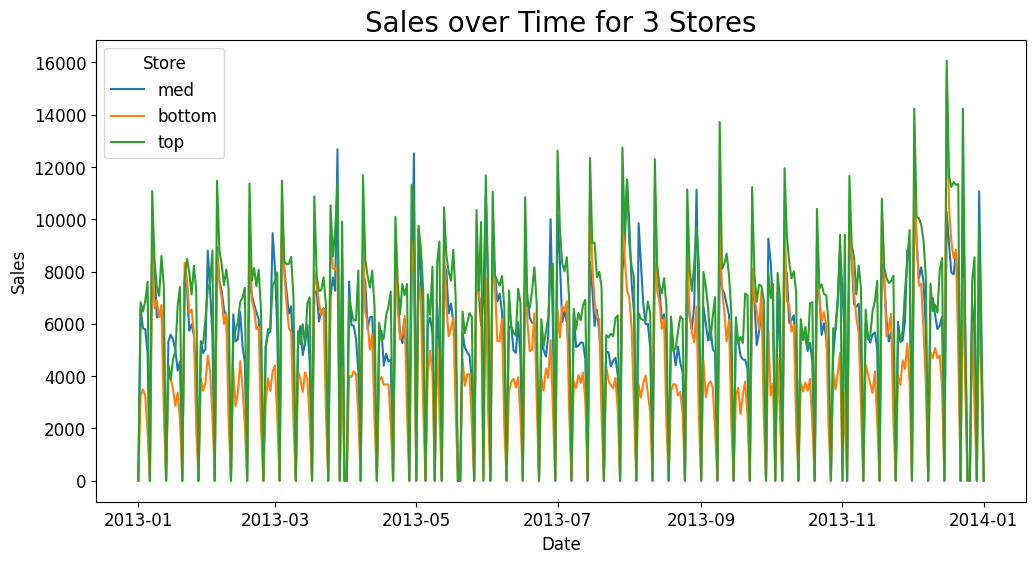

In [41]:
_, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(ax= ax, x= df_year.index, y = df_year.Sales, hue = df_year.Store )
plt.title('Sales over Time for 3 Stores', size=20)
#plt.savefig('sales_over_time_for_3stores', bbox_inches = 'tight')
plt.show()

In [42]:
df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [43]:
# drop columns with missing values
df = df.dropna(how= 'all', axis=1)

# drop DayOfWeek column, StoreType, Assortment
df = df.drop(columns= ['DayOfWeek', 'StoreType', 'Assortment'])

In [44]:
df['IsStateHoliday']= df['StateHoliday'].apply(lambda y: 1 if y in ['a', 'b', 'c'] else 0)

In [45]:
# Aggregate data by store and resample over a month period

agg_df = df.groupby('Store').resample('M').mean()
agg_df.reset_index(inplace= True)

agg_df.head(4)

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,IsStateHoliday
0,bottom,2013-01-31,"3,956.58",378.48,0.84,0.32,0.13,960.00,5.00,"2,008.00",1.00,13.00,"2,010.00",0.06
1,bottom,2013-02-28,"4,178.68",394.96,0.86,0.36,0.18,960.00,5.00,"2,008.00",1.00,13.00,"2,010.00",0.00
2,bottom,2013-03-31,"4,633.84",421.35,0.81,0.48,0.16,960.00,5.00,"2,008.00",1.00,13.00,"2,010.00",0.03
3,bottom,2013-04-30,"4,245.40",404.17,0.83,0.40,0.17,960.00,5.00,"2,008.00",1.00,13.00,"2,010.00",0.03


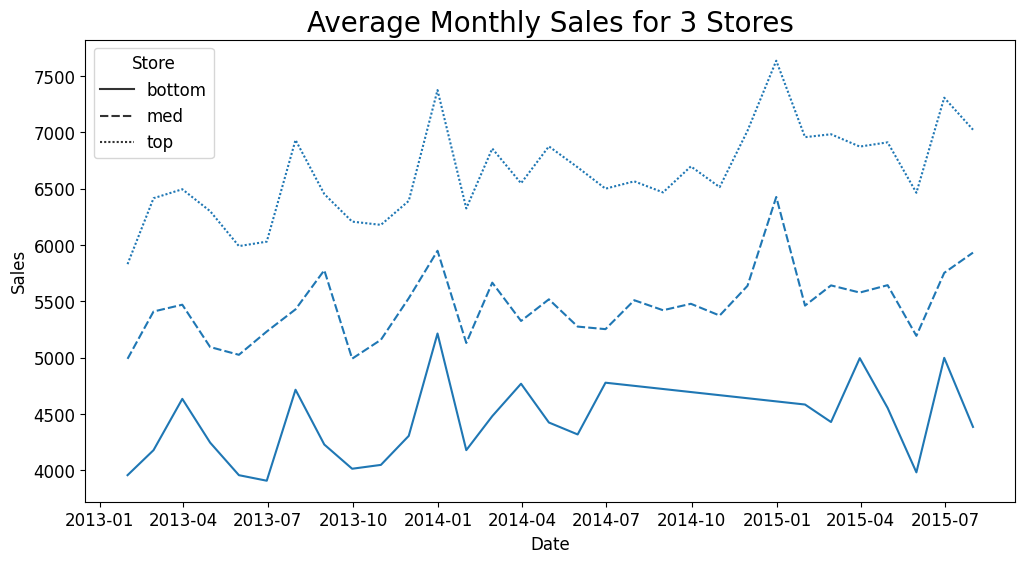

In [46]:
_, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(ax= ax, x= agg_df.Date, y = agg_df.Sales, style = agg_df.Store)
plt.title('Average Monthly Sales for 3 Stores', size=20)
#plt.savefig('avg_monthly_sales_for3stores', bbox_inches = 'tight')
plt.show()

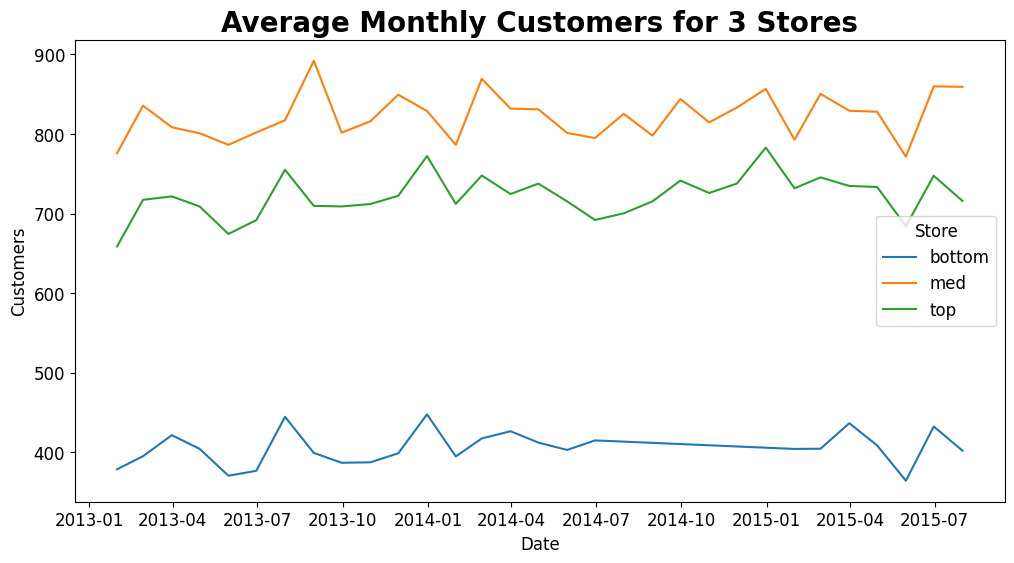

In [47]:
_, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(ax= ax, x= agg_df.Date, y = agg_df.Customers, hue = agg_df.Store )
plt.title('Average Monthly Customers for 3 Stores', size=20, fontweight='bold')
#plt.savefig('avg_monthly_customers_for3stores', bbox_inches = 'tight')
plt.show()

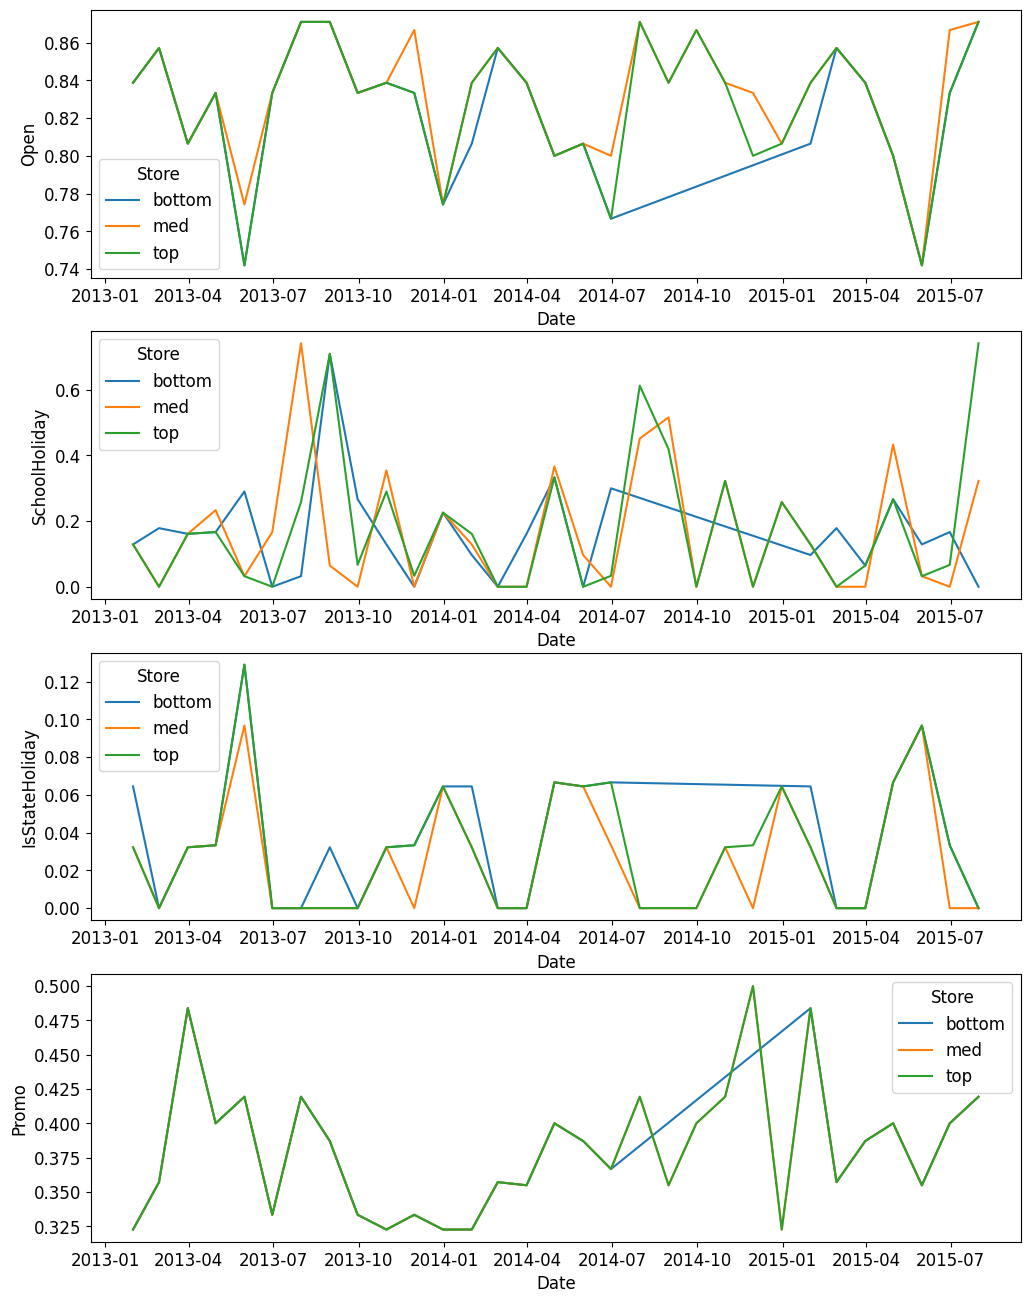

In [48]:
_, axes = plt.subplots(4,1, figsize=(12, 16))
sns.lineplot(ax= axes[0], x= agg_df.Date, y = agg_df.Open, hue = agg_df.Store )
sns.lineplot(ax= axes[1], x= agg_df.Date, y = agg_df.SchoolHoliday, hue = agg_df.Store )
sns.lineplot(ax= axes[2], x= agg_df.Date, y = agg_df.IsStateHoliday, hue = agg_df.Store )
sns.lineplot(ax= axes[3], x= agg_df.Date, y = agg_df.Promo, hue = agg_df.Store )
#plt.title('Ratio Store was open over Time', size=20, fontweight='bold')
#plt.savefig('monthly_ratios_for3stores', bbox_inches = 'tight')
plt.show()


In the plots we notice that 
- There is seasonality in the sales

- The store with better performance than 75% of stores had more promos 

- More customers does NOT mean more sales, see median performing store had more customers than a store in the 75% percentile.

In [49]:
# Lets take the median store

In [50]:
# df['StateHoliday'] = df['StateHoliday'].apply(lambda x: {'a':'Public', 'b': 'Easter', 'c': 'Chrismas', '0': 'No hday', 0: 'No hday'}[x])
med_df = df[df.Store=='med'].resample('w').mean()

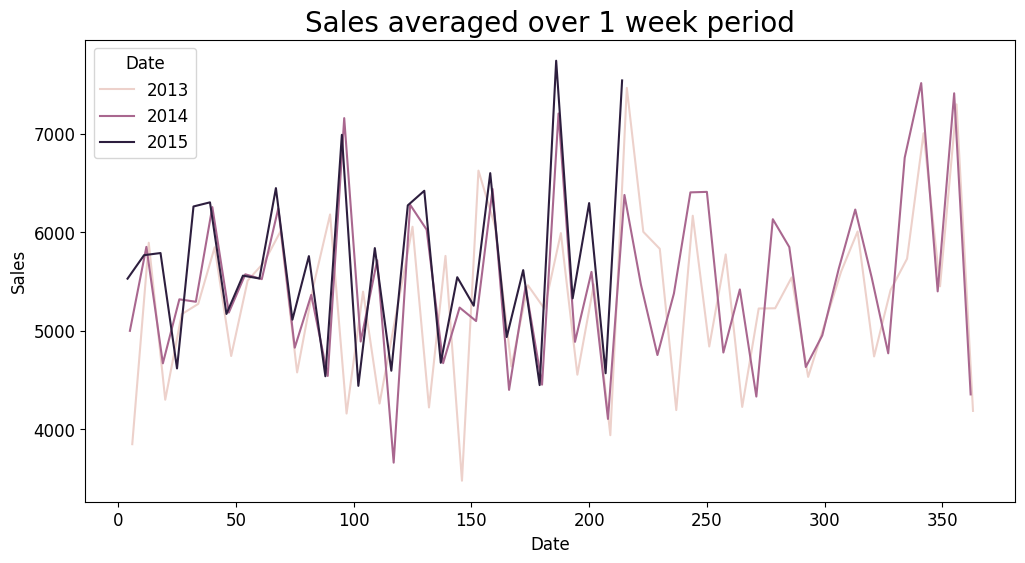

In [51]:
_, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(ax= ax, x= med_df.index.dayofyear, y = med_df.Sales, hue=med_df.index.year)
plt.title('Sales averaged over 1 week period', size=20)
#plt.savefig('weekly_avg_sales_for1store', bbox_inches = 'tight')
plt.show()

There is a clear seasonal effect. As sales of different years seam to almost align on top of each other

## Multivariate Analysis

### Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

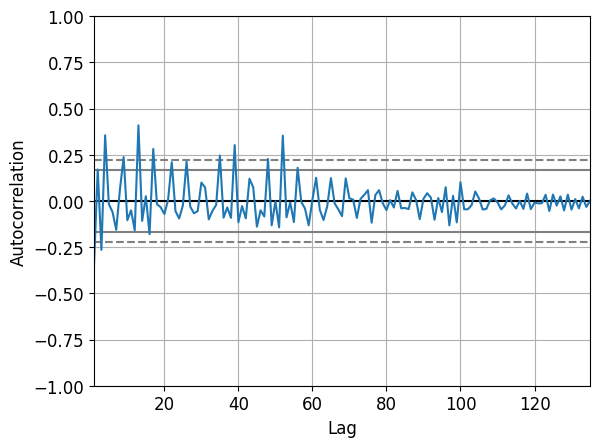

In [52]:
pd.plotting.autocorrelation_plot(med_df['Sales'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

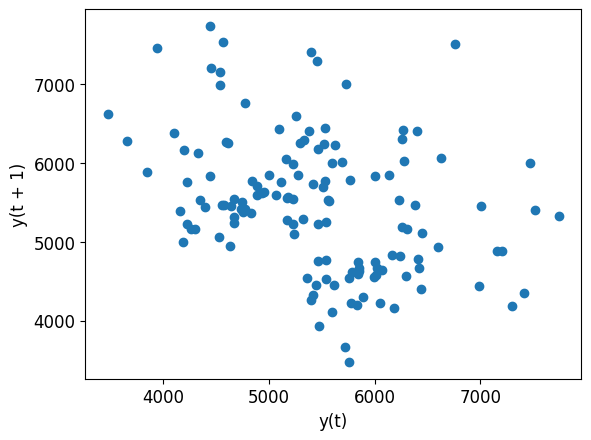

In [53]:
pd.plotting.lag_plot(med_df['Sales'],lag=1) #sales data with a lag of 1 week

## Scatter Plots

In [54]:
# Aggregate data by store and resample over a week period

agg_df = df.groupby('Store').resample('w').mean()
agg_df.reset_index(inplace= True)

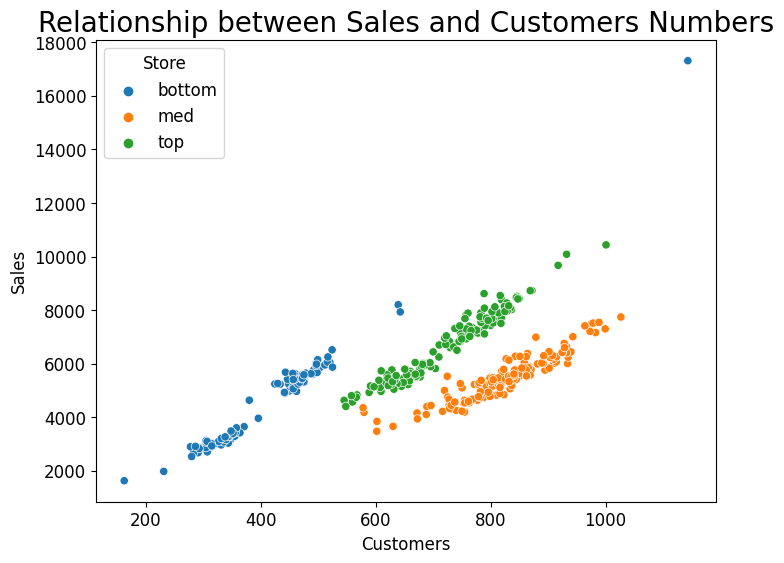

In [55]:
_, ax = plt.subplots(1, figsize=(8, 6))
sns.scatterplot(ax= ax, x= agg_df.Customers, y = agg_df.Sales, hue = agg_df.Store)
plt.title('Relationship between Sales and Customers Numbers', size=20)
#plt.savefig('sales_vs_customers', bbox_inches = 'tight')
plt.show()

There is a clear correlation between the number of customers and sales. The relationship is almost linear.

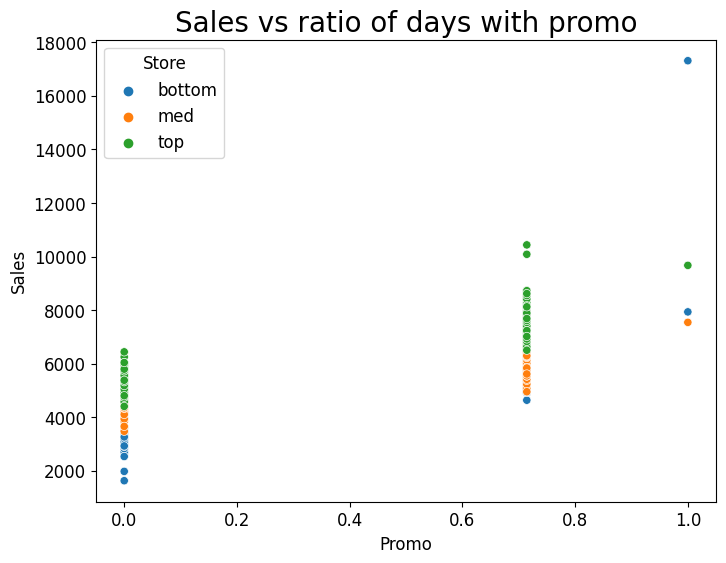

In [56]:
_, ax = plt.subplots(1, figsize=(8, 6))
sns.scatterplot(ax= ax, x= agg_df.Promo, y = agg_df.Sales, hue = agg_df.Store)
plt.title('Sales vs ratio of days with promo', size=20)
#plt.savefig('sales_vs_promos', bbox_inches = 'tight')
plt.show()

There seem to be a positive correlation between sales, and the ratio of days the stores is running promos.

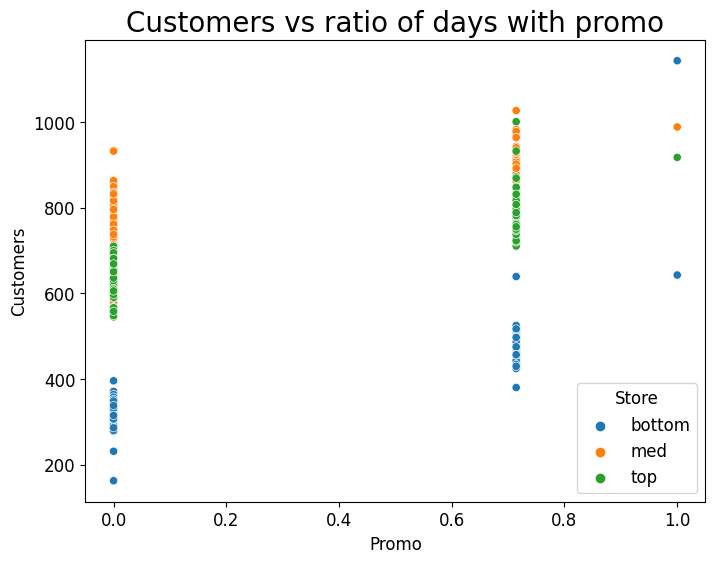

In [57]:
_, ax = plt.subplots(1, figsize=(8, 6))
sns.scatterplot(ax= ax, x= agg_df.Promo, y = agg_df.Customers, hue = agg_df.Store)
plt.title('Customers vs ratio of days with promo', size=20)
#plt.savefig('customers_vs_promos', bbox_inches = 'tight')
plt.show()

There seems to be somewhat of a positive correlation between number of customers, and the ratio of days the stores are running promos.

In [58]:
train['IsWeekend'] = train['DayOfWeek'].apply(lambda x: 0 if x<6 else 1)
test['IsWeekend'] = test['DayOfWeek'].apply(lambda x: 0 if x<6 else 1)

In [59]:
# stores open on weekend
#open_on_wknd = train[(train.Open == 1) & (train.IsWeekend == 1)]

# stores open on weekday
#open_on_wkd = train[(train.Open == 1) & (train.IsWeekend == 0)]

In [60]:
train_open = train[train.Open==1]

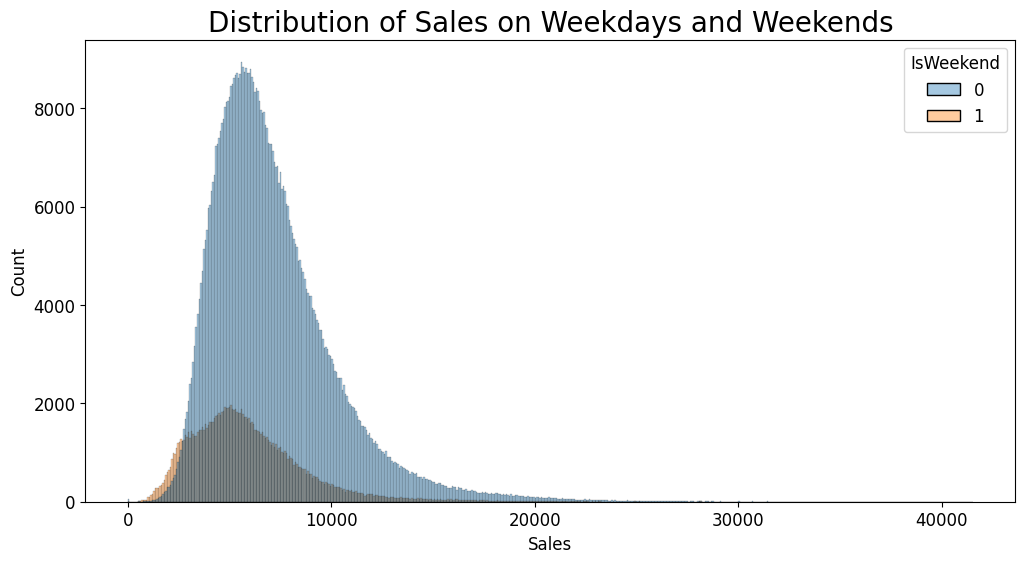

In [61]:
_, ax = plt.subplots(1, figsize=(12, 6))
sns.histplot(ax= ax, x= train_open.Sales, alpha = 0.4, hue = train_open.IsWeekend)
plt.title('Distribution of Sales on Weekdays and Weekends', size=20)
#plt.savefig('dist_sales_weekday_weekends', bbox_inches = 'tight')
plt.show()

There are slightly more sales on weekdays.

In [62]:
# lets check how the assortment type affects sales
# assortment level: a = basic, b = extra, c = extended

train_open.groupby('Assortment')['Sales'].agg(['mean', 'min', 'median', 'max', 'std'])

,mean,min,median,max,std
Assortment,,,,,
a,"6,621.02",0,"6,082.00",38722,"2,972.50"
b,"8,639.35",0,"8,081.00",22137,"3,806.01"
c,"7,300.53",0,"6,675.00",41551,"3,184.14"


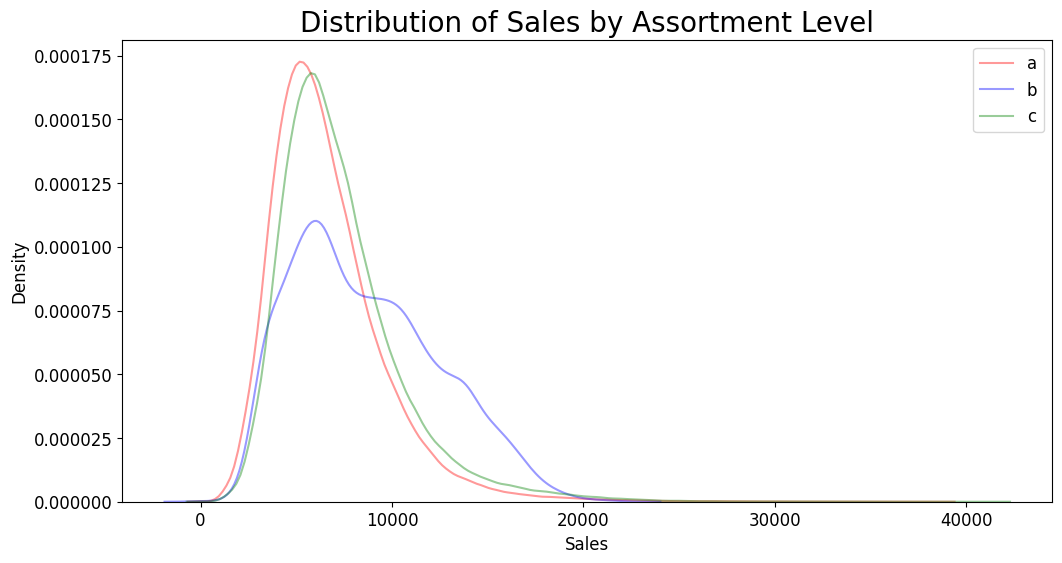

In [63]:
_, ax = plt.subplots(1, figsize=(12, 6))
sns.kdeplot(ax= ax, x= train_open[train_open.Assortment == 'a'].Sales, alpha = 0.4, color='red', label= 'a')
sns.kdeplot(ax= ax, x= train_open[train_open.Assortment == 'b'].Sales, alpha = 0.4, color='blue', label= 'b')
sns.kdeplot(ax= ax, x= train_open[train_open.Assortment == 'c'].Sales, alpha = 0.4, color='green', label= 'c')
ax.legend()
plt.title('Distribution of Sales by Assortment Level', size=20)
#plt.savefig('dist_sales_by_assortment', bbox_inches = 'tight')
plt.show()

We notice that assortment level b = extra is connected to more sales on average.

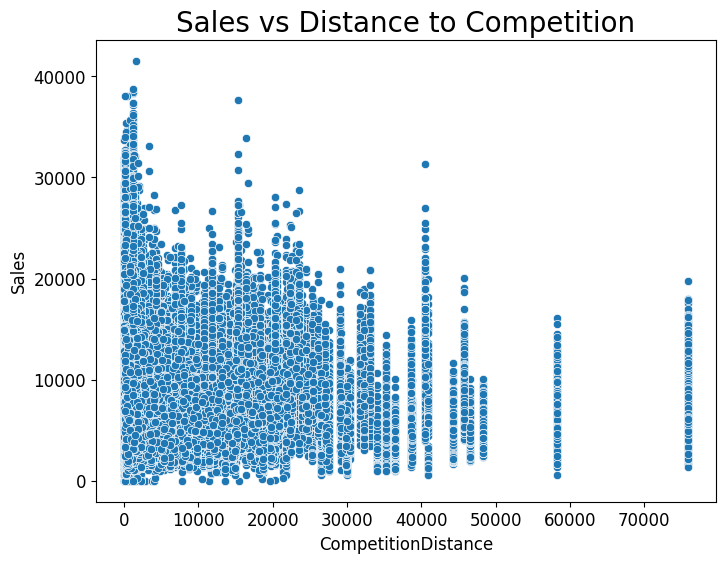

In [64]:
_, ax = plt.subplots(1, figsize=(8, 6))
sns.scatterplot(ax= ax, x= train_open.CompetitionDistance, y = train_open.Sales)
plt.title('Sales vs Distance to Competition', size=20)
#plt.savefig('sales_vs_dist', bbox_inches = 'tight')
plt.show()

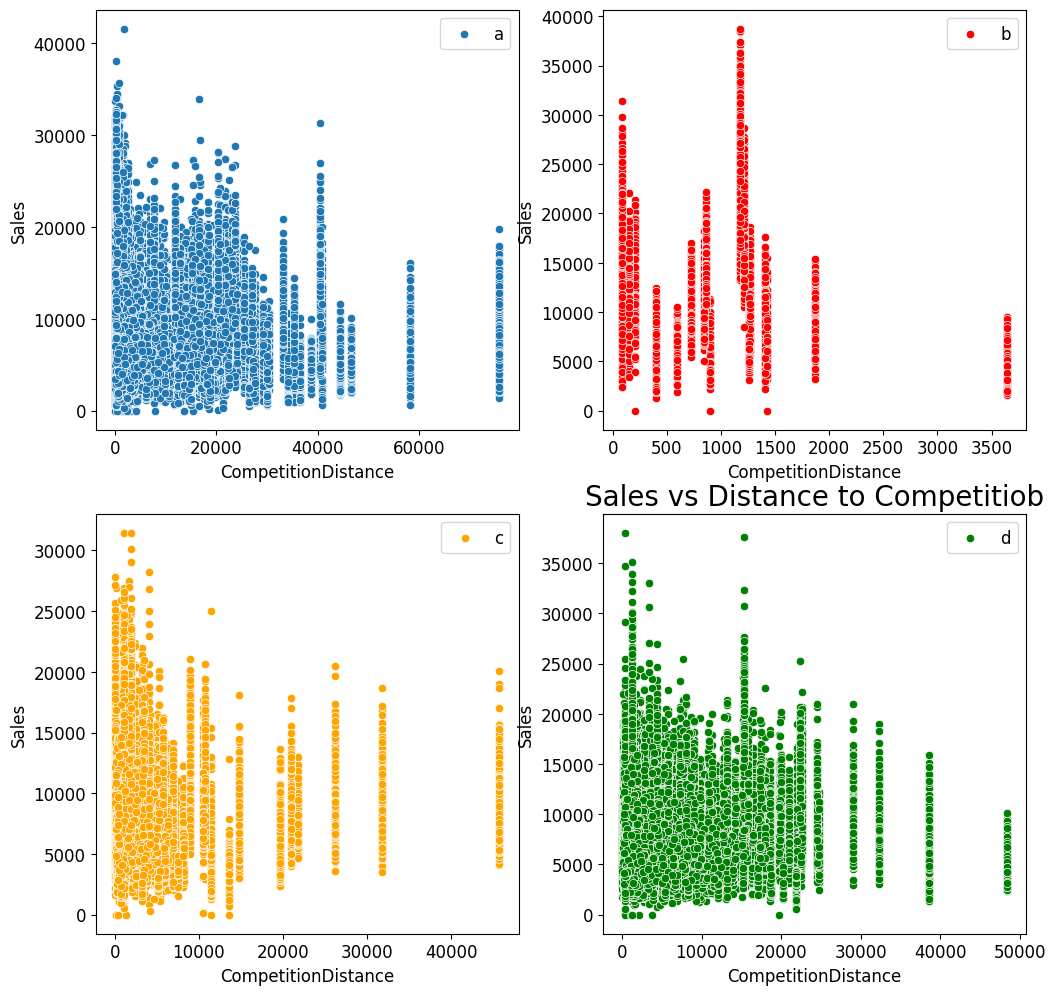

In [65]:
_, axes = plt.subplots(2,2, figsize=(12, 12))
sns.scatterplot(ax= axes[0,0], x= train_open[train_open.StoreType == 'a'].CompetitionDistance, 
                y = train_open[train_open.StoreType == 'a'].Sales, label= 'a')
sns.scatterplot(ax= axes[0,1], x= train_open[train_open.StoreType == 'b'].CompetitionDistance, 
                y = train_open[train_open.StoreType == 'b'].Sales, label= 'b', color = 'red')
sns.scatterplot(ax= axes[1,0], x= train_open[train_open.StoreType == 'c'].CompetitionDistance, 
                y = train_open[train_open.StoreType == 'c'].Sales, label= 'c', color = 'orange')
sns.scatterplot(ax= axes[1,1], x= train_open[train_open.StoreType == 'd'].CompetitionDistance, 
                y = train_open[train_open.StoreType == 'd'].Sales, label= 'd', color = 'green')
plt.title('Sales vs Distance to Competitiob', size=20)
#plt.savefig('sales_vs_distance_storetype', bbox_inches = 'tight')
plt.show()

There is no obvious relation between sales and distance to nearest competition. This could be because if the store and its competitors all happen to be in city centers, the distance won't matter. 

# Writing out Datasets

In [66]:
train.to_csv('../data/train.csv')
test.to_csv('../data/test.csv')